In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from math import ceil

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    average_precision_score, roc_auc_score, precision_recall_curve, roc_curve,
    f1_score, precision_score, recall_score, confusion_matrix
)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# **1. Diagnostyka, sprawdzenie braków**

In [5]:
df = pd.read_csv("/content/creditcard.csv")
print(f"Wymiary danych: {df.shape}")
print("\nKolumny:")
print(df.columns.tolist())

Wymiary danych: (284807, 31)

Kolumny:
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [6]:
print("\nTypy danych:")
print(df.dtypes.value_counts())


Typy danych:
float64    30
int64       1
Name: count, dtype: int64


In [7]:
display(df.head())
display(df.describe())

#Sprawdzenie braków
print("\nBraki danych:")
print(df.isna().sum().sum())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000



Braki danych:
0


In [8]:
TARGET = "Class"
print(df[TARGET].value_counts(normalize=True).rename("ratio"))

Class
0    0.998273
1    0.001727
Name: ratio, dtype: float64


## 2. Podział: train / valid / test

In [9]:
# 60% train, 20% valid, 20% test — wszystko stratyfikowane
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp
)  # 0.25 z 0.80 = 0.20 całych danych

print("Kształty:")
print("Train:", X_train.shape, " Valid:", X_valid.shape, " Test:", X_test.shape)
print("Udział fraudów:")
for name, yy in [("train", y_train), ("valid", y_valid), ("test", y_test)]:
    print(name, f"{yy.mean():.5f}")

Kształty:
Train: (170883, 30)  Valid: (56962, 30)  Test: (56962, 30)
Udział fraudów:
train 0.00173
valid 0.00174
test 0.00172


## 3. Standaryzacja i PCA

In [10]:
# fit na train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)

# PCA: tyle komponentów żeby wyjaśnić >=95% wariancji
pca = PCA(n_components=0.95, svd_solver="full", random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print(f"Liczba komponentów PCA (>=95% wariancji): {pca.n_components_} z {X.shape[1]}")

Liczba komponentów PCA (>=95% wariancji): 27 z 30


## 4. Zbilansowanie danych treningowych
Opcja wyboru między smote lub undersample w zmiennej "method"

In [11]:

method = "smote"   # <- zmień na "smote" / "undersample"
ratio_neg_to_pos = 20     # docelowy stosunek klasy 0:1 na zbiorze treningowym

y_pos = y_train.sum()
n_pos_target = int(y_pos)  # fraudów nie zmieniamy przy undersamplingu
n_neg_target = int(ratio_neg_to_pos * n_pos_target)

if method == "undersample":
    rus = RandomUnderSampler(
        sampling_strategy={0: n_neg_target, 1: n_pos_target},
        random_state=RANDOM_STATE
    )
    X_train_bal, y_train_bal = rus.fit_resample(X_train_pca, y_train)

elif method == "smote":
    from collections import Counter
    cnt = Counter(y_train)
    n_neg = cnt[0]
    n_pos_target = max(1, n_neg // ratio_neg_to_pos)
    sm = SMOTE(
        sampling_strategy={1: n_pos_target},
        random_state=RANDOM_STATE,
        k_neighbors=5
    )
    X_train_bal, y_train_bal = sm.fit_resample(X_train_pca, y_train)
else:
    raise ValueError("method musi być 'undersample' lub 'smote'")

print("Po balansowaniu (tylko train):")
unique, counts = np.unique(y_train_bal, return_counts=True)
print(dict(zip(unique, counts)))

Po balansowaniu (tylko train):
{np.int64(0): np.int64(170588), np.int64(1): np.int64(8529)}


## funkcje pomocnicze - do ewaluacji

In [12]:
#  Funkcje ewaluacyjne
def choose_threshold_by_f1(y_true, y_proba):
    # dobór progu maksymalizującego F1 na walidacji
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    precisions, recalls = precisions[:-1], recalls[:-1]
    thresholds = thresholds
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
    best_idx = np.argmax(f1s)
    return thresholds[best_idx], f1s[best_idx], precisions[best_idx], recalls[best_idx]

def recall_at_k_percent(y_true, y_proba, k=5):
    # recall@k%: bierzemy top k% najwyższych prawdopodobieństw
    n = len(y_proba)
    top_n = max(1, ceil(n * (k / 100.0)))
    idx = np.argsort(-y_proba)[:top_n]
    return y_true.iloc[idx].sum() / y_true.sum()

def evaluate_model(name, clf, X_tr, y_tr, X_va, y_va, X_te, y_te):
    # trening
    clf.fit(X_tr, y_tr)

    if hasattr(clf, "predict_proba"):
        proba_val = clf.predict_proba(X_va)[:, 1]
        proba_test = clf.predict_proba(X_te)[:, 1]
    else:

        proba_val = clf.decision_function(X_va)
        proba_test = clf.decision_function(X_te)

    # metryki na walidacji - wybór modelu
    pr_auc_val = average_precision_score(y_va, proba_val)  # PR-AUC
    roc_auc_val = roc_auc_score(y_va, proba_val)

    # dobór progu na walidacji
    thr, best_f1_val, p_val, r_val = choose_threshold_by_f1(y_va, proba_val)

    # raport końcowy
    y_pred_test = (proba_test >= thr).astype(int)
    pr_auc_test = average_precision_score(y_te, proba_test)
    roc_auc_test = roc_auc_score(y_te, proba_test)
    f1_test = f1_score(y_te, y_pred_test)
    prec_test = precision_score(y_te, y_pred_test, zero_division=0)
    rec_test = recall_score(y_te, y_pred_test, zero_division=0)
    rec_at_1 = recall_at_k_percent(y_te, proba_test, k=1)
    rec_at_5 = recall_at_k_percent(y_te, proba_test, k=5)

    # macierz pomyłek
    cm = confusion_matrix(y_te, y_pred_test)

    results = {
        "name": name,
        "threshold_val": thr,
        "val_pr_auc": pr_auc_val,
        "val_roc_auc": roc_auc_val,
        "val_f1_best": best_f1_val,
        "test_pr_auc": pr_auc_test,
        "test_roc_auc": roc_auc_test,
        "test_f1": f1_test,
        "test_precision": prec_test,
        "test_recall": rec_test,
        "test_recall@1%": rec_at_1,
        "test_recall@5%": rec_at_5,
        "confusion_matrix_test": cm,
    }
    return results, proba_val, proba_test

In [16]:
#  MODELE - 3 różne
models = []

# 1) Logistic Regression
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=None
)
models.append(("LogisticRegression", lr))

# 2) Random Forest
rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    min_samples_leaf=1,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE
)
models.append(("RandomForest", rf))

# 3) XGBoost
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist",
    eval_metric="logloss",
    scale_pos_weight=(y_train_bal.value_counts()[0] / y_train_bal.value_counts()[1]) if isinstance(y_train_bal, pd.Series) else 1.0
)
models.append(("XGBoost", xgb))

results_list = []
probas_val = {}
probas_test = {}

for name, clf in models:
    res, pval, ptest = evaluate_model(
        name, clf,
        X_train_bal, y_train_bal,
        X_valid_pca, y_valid,
        X_test_pca, y_test
    )
    results_list.append(res)
    probas_val[name] = pval
    probas_test[name] = ptest

# Wyniki w tabeli
res_df = pd.DataFrame(results_list).drop(columns=["confusion_matrix_test"])
display(res_df.sort_values("val_pr_auc", ascending=False).reset_index(drop=True))

,name,threshold_val,val_pr_auc,val_roc_auc,val_f1_best,test_pr_auc,test_roc_auc,test_f1,test_precision,test_recall,test_recall@1%,test_recall@5%
0,RandomForest,0.418333,0.791104,0.973746,0.787234,0.841717,0.971704,0.800000,0.804124,0.795918,0.897959,0.948980
1,XGBoost,0.994556,0.782631,0.974333,0.804598,0.850847,0.964457,0.845714,0.961039,0.755102,0.908163,0.928571
2,LogisticRegression,0.999994,0.697104,0.972126,0.787234,0.714947,0.972720,0.788462,0.745455,0.836735,0.887755,0.918367


Najlepszy (walidacja PR-AUC): XGBoost


<Figure size 600x400 with 0 Axes>

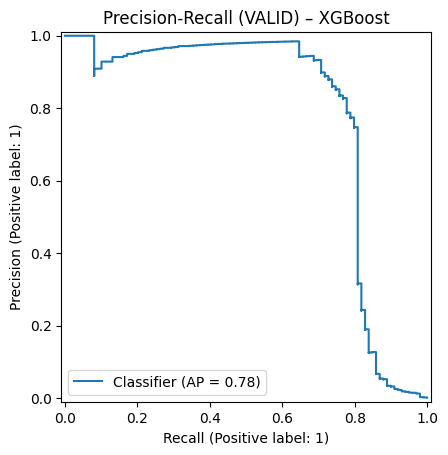

<Figure size 600x400 with 0 Axes>

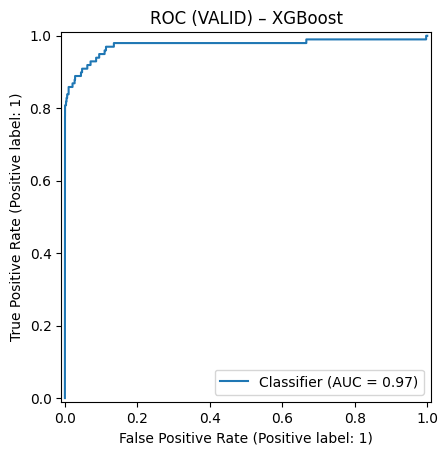

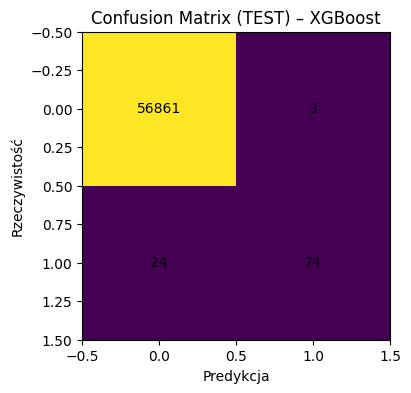

In [19]:

res_sorted = sorted(results_list, key=lambda d: d["test_pr_auc"], reverse=True)
best = res_sorted[0]
best_name = best["name"]
print(f"Najlepszy (walidacja PR-AUC): {best_name}")

# PR/ROC na walidacji
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

plt.figure(figsize=(6,4))
PrecisionRecallDisplay.from_predictions(y_valid, probas_val[best_name])
plt.title(f"Precision-Recall (VALID) – {best_name}")
plt.show()

plt.figure(figsize=(6,4))
RocCurveDisplay.from_predictions(y_valid, probas_val[best_name])
plt.title(f"ROC (VALID) – {best_name}")
plt.show()


cm = [r for r in results_list if r["name"] == best_name][0]["confusion_matrix_test"]
plt.figure(figsize=(4,4))
plt.imshow(cm)
plt.title(f"Confusion Matrix (TEST) – {best_name}")
plt.xlabel("Predykcja")
plt.ylabel("Rzeczywistość")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.show()

Uzasadnienie wyboru modelu:

W celu klasyfikacji transakcji przetestowano trzy modele: regresję logistyczną, las losowy oraz XGBoost.

Wszystkie  zostały nauczone na zbiorze treningowym po wcześniejszym przygotowaniu danych - standaryzację, redukcję wymiarów metodą PCA (z zachowaniem 95% wariancji) oraz częściowe zbilansowanie próby (stosunek 1:20 na zbiorze treningowym). Ostateczna ocena modeli została przeprowadzona na niezależnym zbiorze testowym, zachowującym rzeczywisty, niezbalansowany rozkład klas.

Porównanie wyników wskazuje, że XGBoost osiągnął najwyższą skuteczność spośród analizowanych modeli. Otrzymał on najwyższą wartość miary PR-AUC (0.85), która jest najbardziej adekwatna w przypadku silnie niezbalansowanych danych, oraz najwyższy wynik F1-score (0.846), potwierdzający najlepszy kompromis pomiędzy precyzją a czułością.

XGBoost charakteryzował się również bardzo wysoką precyzją (0.96), co oznacza, że generował najmniej fałszywych alarmów, przy jednocześnie satysfakcjonującej czułości (0.75). Wskaźniki Recall@1% = 0.91 i Recall@5% = 0.93 dowodzą, że aż 91% transakcji oszukańczych zostało zidentyfikowanych w 1% najbardziej podejrzanych przypadków.
Dla porównania, model lasu losowego uzyskał nieco niższe wartości PR-AUC (0.84) i F1-score (0.80), natomiast regresja logistyczna, jako model liniowy wykazała najniższą skuteczność (PR-AUC 0.71), co potwierdza, że relacje w danych mają charakter nieliniowy.

Podsumowując, XGBoost okazał się najlepszym modelem.

Modele - wybór z AutoGluon

In [1]:
!pip install autogluon

wariant z autogluon - bardzo długi czas wykonania (ostatecznie nie wykorzystałem)


In [15]:
#  AutoGluon
from autogluon.tabular import TabularDataset, TabularPredictor

# Składamy DataFrame z PCA (kolumny bez nazw — nadamy syntetyczne)
def to_df(mat, y=None):
    cols = [f"PC{i+1}" for i in range(mat.shape[1])]
    out = pd.DataFrame(mat, columns=cols)
    if y is not None:
        out[TARGET] = y.values if isinstance(y, pd.Series) else y
    return out

train_ag = to_df(X_train_bal, y_train_bal)
valid_ag = to_df(X_valid_pca, y_valid)
test_ag  = to_df(X_test_pca, y_test)

save_path = "/content/autogluon_fraud"
predictor = TabularPredictor(
    label=TARGET, problem_type="binary", eval_metric="average_precision",
    path=save_path
).fit(
    train_data=train_ag,
    tuning_data=valid_ag,
    presets="best_quality",
    time_limit=None,
    use_bag_holdout=True
)

lb = predictor.leaderboard(valid_ag, silent=True)
display(lb.head(10))

# wybór Top-3 modeli (PR-AUC itp.) na teście:
top3 = lb.sort_values("score_val", ascending=False).head(3)["model"].tolist()
print("Top-3 z AutoGluon:", top3)

ag_results = []
for m in top3:
    proba_val = predictor.predict_proba(valid_ag, model=m)[1].values
    proba_test = predictor.predict_proba(test_ag, model=m)[1].values

    pr_auc_val = average_precision_score(y_valid, proba_val)
    roc_auc_val = roc_auc_score(y_valid, proba_val)

    thr, f1v, pv, rv = choose_threshold_by_f1(y_valid, proba_val)
    y_pred_test = (proba_test >= thr).astype(int)

    pr_auc_test = average_precision_score(y_test, proba_test)
    roc_auc_test = roc_auc_score(y_test, proba_test)
    f1_test = f1_score(y_test, y_pred_test)
    prec_test = precision_score(y_test, y_pred_test, zero_division=0)
    rec_test = recall_score(y_test, y_pred_test, zero_division=0)
    rec_at_1 = recall_at_k_percent(y_test, proba_test, k=1)
    rec_at_5 = recall_at_k_percent(y_test, proba_test, k=5)
    cm = confusion_matrix(y_test, y_pred_test)

    ag_results.append({
        "name": f"AutoGluon::{m}",
        "threshold_val": thr,
        "val_pr_auc": pr_auc_val,
        "val_roc_auc": roc_auc_val,
        "val_f1_best": f1v,
        "test_pr_auc": pr_auc_test,
        "test_roc_auc": roc_auc_test,
        "test_f1": f1_test,
        "test_precision": prec_test,
        "test_recall": rec_test,
        "test_recall@1%": rec_at_1,
        "test_recall@5%": rec_at_5,
        "confusion_matrix_test": cm,
    })

display(pd.DataFrame(ag_results).drop(columns=["confusion_matrix_test"]).sort_values("val_pr_auc", ascending=False))

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       9.83 GB / 12.67 GB (77.6%)
Disk Space Avail:   62.00 GB / 107.72 GB (57.6%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "/content/autogluon_fraud"
Train Data Rows:    17

KeyboardInterrupt: 